In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from collections import Counter
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.interpolate import interp1d
from sklearn.utils import resample
import math
from scipy.stats import wilcoxon

## Load and explore the Metatranscriptomics Data

In [4]:
#Read the file 
meta_trans = pd.read_csv("Metatranscriptomics (KEGG).csv")

In [6]:
meta_trans.shape

(60, 7073)

In [8]:
meta_trans.head()

,Sample_ID,Patient,Timepoint,K00001: alcohol dehydrogenase [EC:1.1.1.1],K00002: alcohol dehydrogenase (NADP+) [EC:1.1.1.2],K00003: homoserine dehydrogenase [EC:1.1.1.3],"K00004: (R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]",K00005: glycerol dehydrogenase [EC:1.1.1.6],K00006: glycerol-3-phosphate dehydrogenase (NAD+) [EC:1.1.1.8],K00008: L-iditol 2-dehydrogenase [EC:1.1.1.14],...,K22988: NO_NAME,K22989: NO_NAME,K22990: NO_NAME,K22991: NO_NAME,K23001: NO_NAME,K23003: NO_NAME,K23004: NO_NAME,K23007: NO_NAME,K23015: NO_NAME,K23016: NO_NAME
0,1A,1,Baseline,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2A,2,Baseline,0.0,0.000000,0.0,0.0,2.798770,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3A,3,Baseline,0.0,0.000000,0.0,0.0,0.996578,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4A,4,Baseline,0.0,0.488329,0.0,0.0,6.075270,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5A,5,Baseline,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Rename the coloumns name to keep only the KO IDs in Columns name

meta_trans.columns = [col.split(":")[0] for col in meta_trans.columns]

In [12]:
#Remove missing values 
meta_trans = meta_trans.dropna()

In [14]:
#Remove low expressed genes 

meta_trans = meta_trans.loc[:, (meta_trans == 0).mean(axis=0) < 0.8]

In [16]:
meta_trans.shape

(58, 2548)

In [18]:
#Filter Data according to timepoints

# Filter only Baseline and Week 4 samples
filtered_b2 = meta_trans[meta_trans['Timepoint'].isin(['Baseline', 'Week 2'])]
filtered_b4 = meta_trans[meta_trans['Timepoint'].isin(['Baseline', 'Week 4'])]
filtered_b8 = meta_trans[meta_trans['Timepoint'].isin(['Baseline', 'Week 8'])]
# Display the result
filtered_b4.head(30)


,Sample_ID,Patient,Timepoint,K00003,K00005,K00009,K00010,K00012,K00013,K00014,...,K22293,K22373,K22431,K22432,K22454,K22456,K22719,K22720,K22900,K22927
0,1A,1,Baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2A,2,Baseline,0.000000,2.798770,0.000000,0.000000,23.941400,0.000000,33.814800,...,0.000000,1.27729,3.23046,5.282250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3A,3,Baseline,0.000000,0.996578,0.000000,0.000000,18.730700,3.735150,107.213000,...,0.790109,37.65820,2.23452,2.562870,0.440444,2.029500,0.000000,2.601520,0.000000,2.817310
3,4A,4,Baseline,0.000000,6.075270,0.000000,0.000000,1.226320,0.000000,5.685480,...,0.000000,3.79893,0.00000,0.000000,2.991020,4.896100,0.000000,0.000000,0.000000,0.000000
4,5A,5,Baseline,0.000000,0.000000,0.000000,0.000000,14.500800,0.000000,45.093100,...,0.000000,29.50640,0.00000,2.656070,2.686890,5.138600,0.000000,0.000000,0.000000,0.000000
5,6A,6,Baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7A,7,Baseline,0.000000,1.576310,0.000000,1.037020,3.177790,2.784120,12.339200,...,1.459040,10.06420,0.00000,0.000000,0.398780,0.316875,0.000000,0.104939,0.000000,9.740470
7,8A,8,Baseline,0.000000,6.266730,0.000000,0.000000,7.344350,3.411310,8.530430,...,0.000000,23.16370,3.57893,5.061650,0.000000,1.204240,0.000000,12.193000,0.000000,0.000000
8,9A,9,Baseline,0.000000,22.642200,0.000000,0.000000,0.000000,3.595150,3.167670,...,2.403180,156.41600,0.00000,1.469390,0.000000,0.477195,0.000000,0.000000,1.795960,11.685000
9,10A,10,Baseline,0.000000,0.000000,0.000000,0.000000,4.957760,0.000000,10.983100,...,0.000000,3.12761,0.00000,0.564947,0.000000,0.244412,0.000000,0.000000,0.000000,0.000000


In [13]:
# Seperate meta data from metatranscriptomic

#baseline vs week 2
y_2 = filtered_b2["Timepoint"]
x_2 = filtered_b2.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#baseline vs week 4 
y_4 = filtered_b4["Timepoint"]
x_4 = filtered_b4.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#baseline vs week 8

y_8 = filtered_b8["Timepoint"]
x_8 = filtered_b8.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#all 

y = meta_trans['Timepoint']
x = meta_trans.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

In [14]:
# Log transform the xs

log_X2 = np.log1p(x_2)
log_X4 = np.log1p(x_4)
log_X8 = np.log1p(x_8)
log_X = np.log1p(x)

## PCA Baselinve vs. Week 2 

In [16]:
#perfome PCA on logged data 

pca = PCA(n_components = 2)
pca_result2 = pca.fit_transform(log_X2)

In [17]:
# Helper function to draw ellipse
def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        scale_factor = np.sqrt(chi2.ppf(0.95, df=2))  # ~2.4477
        width, height = 2 * scale_factor * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    ellipse = Ellipse(xy=position, width = width, height = height, angle = angle, **kwargs)
    ax.add_patch(ellipse)

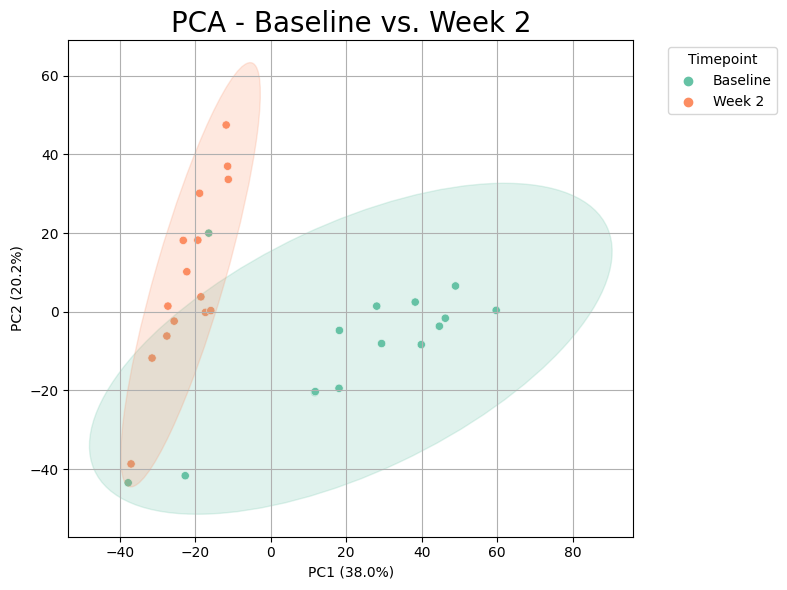

In [18]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_2 = pd.DataFrame(pca_result2[:, :2], columns=['PC1', 'PC2'], index=filtered_b2.index)

# Step 2: Add Timepoint metadata
pca_df_2['Timepoint'] = y_2

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_2, x='PC1', y='PC2', hue=y_2, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_2['Timepoint'].unique()):
    group = pca_df_2[pca_df_2['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - Baseline vs. Week 2", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_2.png')
plt.show()

## Baseline Vs Week 4 

In [20]:
#perfome PCA on logged data 

#pca = PCA(n_components = 2)
pca_result4 = pca.fit_transform(log_X4)

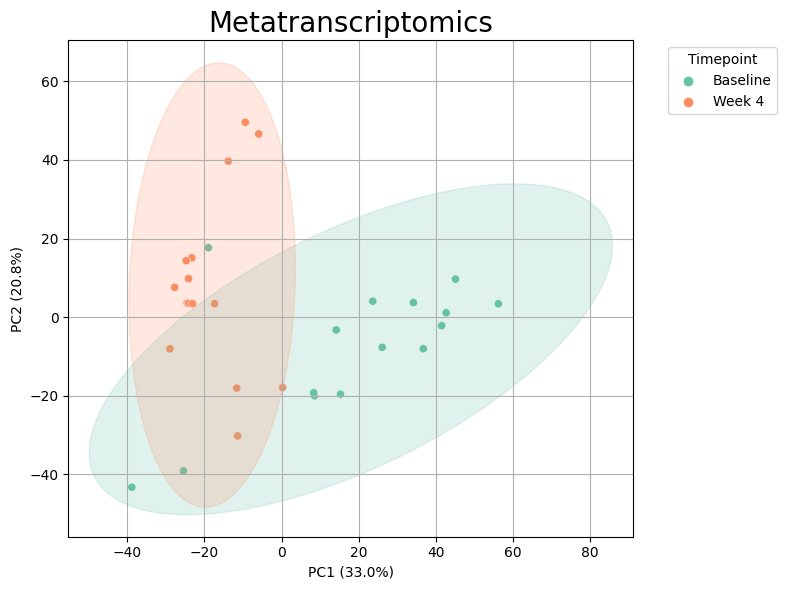

In [21]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_4 = pd.DataFrame(pca_result4[:, :2], columns=['PC1', 'PC2'], index=filtered_b4.index)

# Step 2: Add Timepoint metadata
pca_df_4['Timepoint'] = y_4

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_4, x='PC1', y='PC2', hue=y_4, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_4['Timepoint'].unique()):
    group = pca_df_4[pca_df_4['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("Metatranscriptomics", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_4.png')
plt.show()

## Baseline Vs Week 8

In [23]:
# Perform PCA baseline vs week 8 

pca_result8 = pca.fit_transform(log_X8)

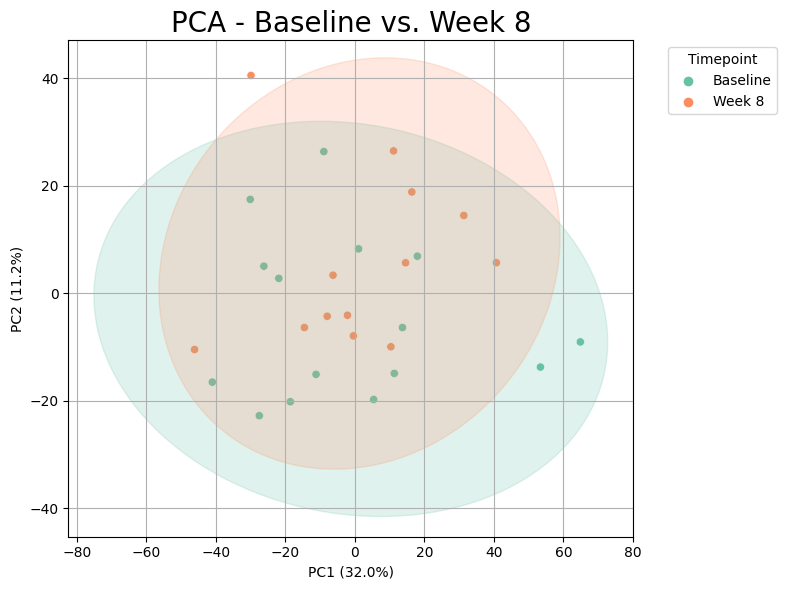

In [24]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_8 = pd.DataFrame(pca_result8[:, :2], columns=['PC1', 'PC2'], index=filtered_b8.index)

# Step 2: Add Timepoint metadata
pca_df_8['Timepoint'] = y_8

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_8, x='PC1', y='PC2', hue=y_8, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_8['Timepoint'].unique()):
    group = pca_df_8[pca_df_8['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - Baseline vs. Week 8", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_8.png')
plt.show()

## All timepoints 

In [26]:
# Perform PCA baseline vs week 8 

pca_result_all = pca.fit_transform(log_X)

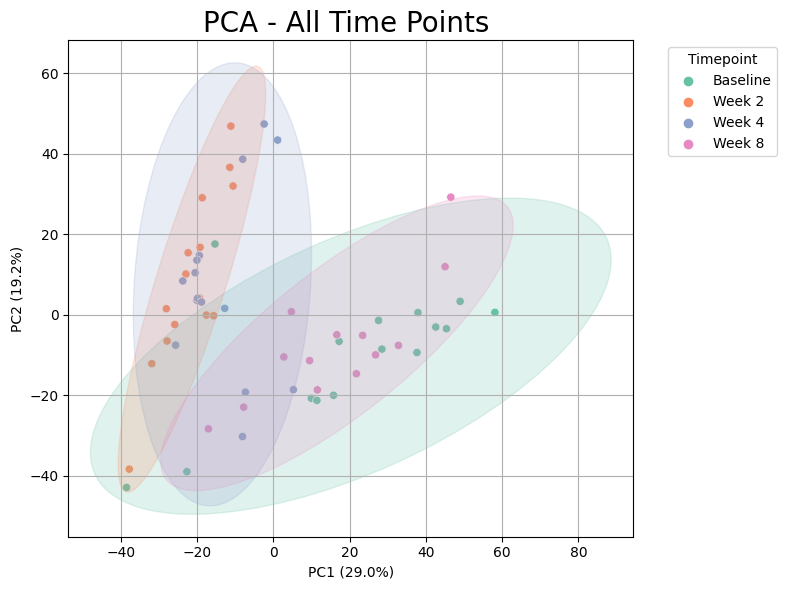

In [27]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_all = pd.DataFrame(pca_result_all[:, :2], columns=['PC1', 'PC2'], index=meta_trans.index)

# Step 2: Add Timepoint metadata
pca_df_all['Timepoint'] = meta_trans['Timepoint']

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_all, x='PC1', y='PC2', hue=y, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_all['Timepoint'].unique()):
    group = pca_df_all[pca_df_all['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - All Time Points ", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_all.png')
plt.show()